In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
data_train = pd.read_csv('../data_cleaned/data_train.csv')
item_categories = pd.read_csv('../data_cleaned/item_categories.csv')
items = pd.read_csv('../data_cleaned/items.csv')
shops = pd.read_csv('../data_cleaned/shops.csv')

In [3]:
merged = data_train.merge(items, how='left').merge(item_categories, how='left').merge(shops, how='left')

In [4]:
merged

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""
4,10.01.2013,0,25,2564,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео,"Москва ТРК ""Атриум"""
...,...,...,...,...,...,...,...,...,...,...
2928480,10.10.2015,33,25,7409,299.00,1.0,V/A Nu Jazz Selection (digipack),55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2928481,09.10.2015,33,25,7460,299.00,1.0,V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2928482,14.10.2015,33,25,7459,349.00,1.0,V/A The Best Of The 3 Tenors,55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2928483,22.10.2015,33,25,7440,299.00,1.0,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,Музыка - MP3,"Москва ТРК ""Атриум"""


In [5]:
dates = pd.to_datetime(merged['date'], format='%d.%m.%Y')


In [6]:
merged['month'] = dates.apply(lambda x:x.month)

In [7]:
merged[['item_name','shop_name','date_block_num','item_price','item_cnt_day']].groupby(['item_name','shop_name','date_block_num']).mean()

item_price  \
item_name                                          shop_name                date_block_num               
! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D          Химки ТЦ "Мега"          20                    58.0   
!ABBYY FineReader 12 Professional Edition Full ... Цифровой склад 1С-Онлайн 15                  4490.0   
                                                                            18                  4490.0   
                                                                            19                  4490.0   
                                                                            20                  4490.0   
...                                                                                                ...   
Яйцо для Little Inu                                Интернет-магазин ЧС      8                    799.0   
                                                   Коломна ТЦ "Рио"         1                    799.0   
                                                   СПб ТК "Невский Центр"   1                    799.0   
                                                   СПб ТК "Сенная"          2                    798.5   
Яйцо дракона (Игра престолов)                      Москва ТРК "Атриум"      14                  4349.0   

                                                                                            item_cnt_day  
item_name                                          shop_name                date_block_num                
! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D          Химки ТЦ "Мега"          20                       1.0  
!ABBYY FineReader 12 Professional Edition Full ... Цифровой склад 1С-Онлайн 15                       1.0  
                                                                            18                       1.0  
                                                                            19                       1.0  
                                                                            20                       1.0  
...                                                                                                  ...  
Яйцо для Little Inu                                Интернет-магазин ЧС      8                        1.0  
                                                   Коломна ТЦ "Рио"         1                        1.0  
                                                   СПб ТК "Невский Центр"   1                        1.0  
                                                   СПб ТК "Сенная"          2                        1.0  
Яйцо дракона (Игра престолов)                      Москва ТРК "Атриум"      14                       1.0  

[1608225 rows x 2 columns]

In [8]:
df=merged.groupby(['shop_id','item_id','date_block_num']).size().reset_index()[0]
df

0          1
1          1
2          1
3          1
4          1
          ..
1608220    2
1608221    1
1608222    1
1608223    2
1608224    1
Name: 0, Length: 1608225, dtype: int64

<Axes: >

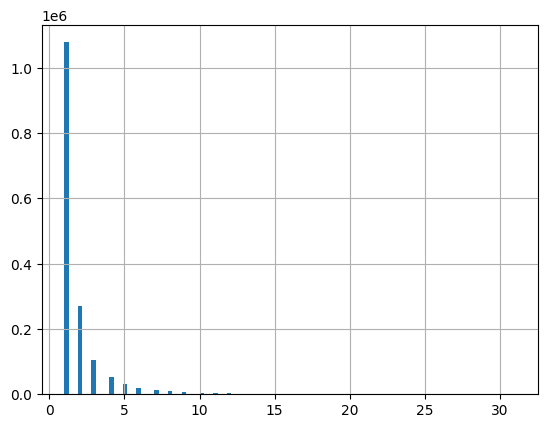

In [9]:
df.hist(bins=100)# - most of products in one shop sold in only one month hist(bins=100)

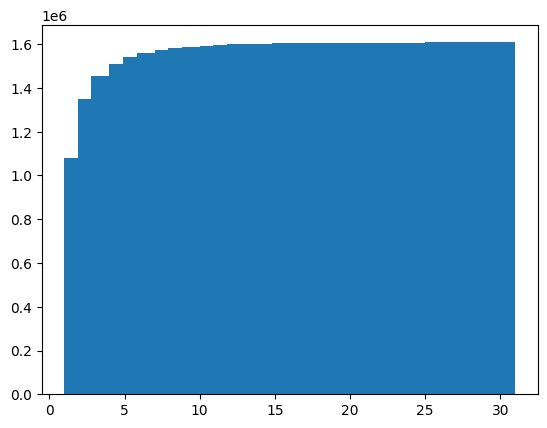

In [10]:
plt.hist(df,bins=100, cumulative=True);

In [11]:
def check_continuity(column_name):
    merged[merged['item_name']==column_name]['date'].nunique() -\
        merged['date'].nunique()
    
    diff=set(merged['date'].unique())-set(merged[merged['item_name']==column_name]['date'].unique())
    print(f'no info about {len(diff)} days')
    max_diff = pd.to_datetime(pd.Series(list(diff)), format='%d.%m.%Y').sort_values().diff().max()
    print('max_diff:',max_diff)
    
    d = merged[merged['item_name']==column_name].groupby('date').agg({'item_cnt_day':'mean'})
    #print(d.reset_index())
    d=d.reset_index()
    
    plt.scatter(pd.to_datetime(pd.Series(list(diff)).sort_values(), format='%d.%m.%Y'),[1]*len(diff),color='red',zorder=-1)
    plt.plot(pd.to_datetime(d['date'], format='%d.%m.%Y').sort_values(),d['item_cnt_day'],zorder=1)
    
#No info about packeti for 113 days - they all are sequent!

no info about 1028 days
max_diff: 2 days 00:00:00


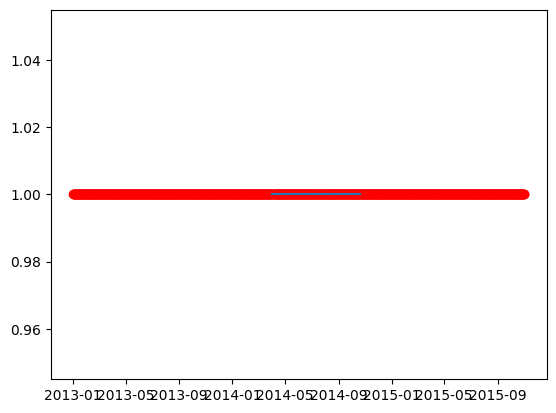

In [12]:
check_continuity('!ABBYY FineReader 12 Professional Edition Full [PC, Цифровая версия]')# - sales per month = sum of sales per day (because misses dont mean no data, they mean 0)

In [13]:
grouped=merged.groupby(['shop_id','item_id','date_block_num']).agg({'item_price':'mean',
                                                                    'item_cnt_day':'sum',
                                                                    'item_category_name':'unique',
                                                                    'month':'unique'})#take some time

In [14]:
grouped=grouped.reset_index()

In [15]:
grouped

,shop_id,item_id,date_block_num,item_price,item_cnt_day,item_category_name,month
0,2,27,0,2499.0,1.0,[Игры - PS3],[1]
1,2,27,17,498.0,1.0,[Игры - PS3],[6]
2,2,30,2,359.0,1.0,[Кино - DVD],[3]
3,2,30,5,399.0,1.0,[Кино - DVD],[6]
4,2,30,15,169.0,1.0,[Кино - DVD],[4]
...,...,...,...,...,...,...,...
1608220,59,22164,27,699.0,2.0,[Кино - Blu-Ray],[4]
1608221,59,22164,30,699.0,1.0,[Кино - Blu-Ray],[7]
1608222,59,22167,9,299.0,1.0,[Книги - Методические материалы 1С],[10]
1608223,59,22167,11,299.0,2.0,[Книги - Методические материалы 1С],[12]


In [16]:
grouped['item_category_name']=grouped['item_category_name'].apply(lambda a:a[0])
grouped['month']=grouped['month'].apply(lambda a:a[0])

In [17]:
grouped=grouped.rename({'item_price':'avg_item_price','item_cnt_day':'item_cnt_month'}, axis='columns')

In [18]:
grouped

,shop_id,item_id,date_block_num,avg_item_price,item_cnt_month,item_category_name,month
0,2,27,0,2499.0,1.0,Игры - PS3,1
1,2,27,17,498.0,1.0,Игры - PS3,6
2,2,30,2,359.0,1.0,Кино - DVD,3
3,2,30,5,399.0,1.0,Кино - DVD,6
4,2,30,15,169.0,1.0,Кино - DVD,4
...,...,...,...,...,...,...,...
1608220,59,22164,27,699.0,2.0,Кино - Blu-Ray,4
1608221,59,22164,30,699.0,1.0,Кино - Blu-Ray,7
1608222,59,22167,9,299.0,1.0,Книги - Методические материалы 1С,10
1608223,59,22167,11,299.0,2.0,Книги - Методические материалы 1С,12


In [19]:
from statsmodels.graphics.tsaplots import plot_pacf

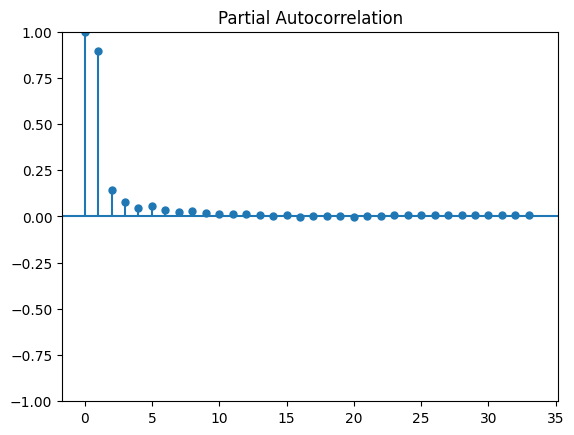

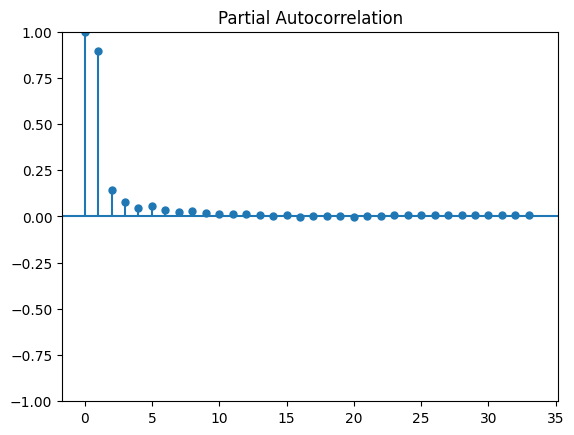

In [20]:
plot_pacf(grouped['avg_item_price'],lags=33)

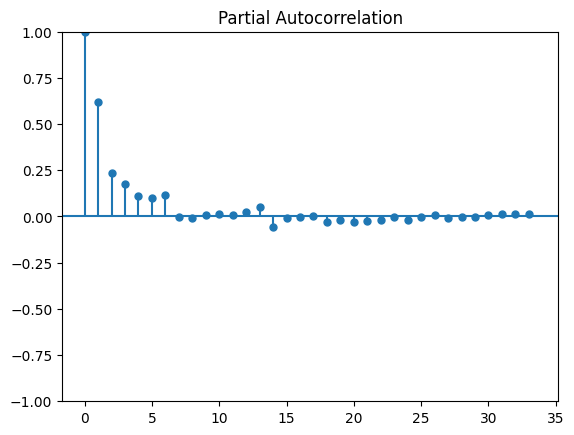

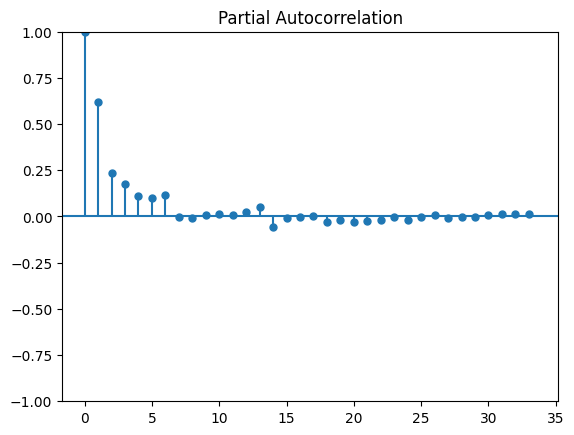

In [21]:
plot_pacf(grouped['item_cnt_month'],lags=33)

In [22]:

def create_lags(data,item_lags=None,price_lags=None):
    lagged_items = data[['date_block_num','item_cnt_month','shop_id','item_id']].copy()
    for lag in item_lags:
        lagged_items['date_block_num']-=lag#previous month becomes present
        data=data.merge(lagged_items, how='left',on=['date_block_num','shop_id','item_id'], suffixes=('', f'_lag_{lag}'))
        lagged_items['date_block_num']+=lag

    lagged_prices = data[['date_block_num','avg_item_price','shop_id','item_id']].copy()
    for lag in price_lags:
        lagged_prices['date_block_num']-=lag#previous month becomes present
        data=data.merge(lagged_prices, how='left',on=['date_block_num','shop_id','item_id'], suffixes=('', f'_lag_{lag}'))
        lagged_prices['date_block_num']+=lag

        
    return data

In [23]:
#list[(*range(1,15),24])

In [24]:
item_lags=list([*range(1,7),12,13,24])
price_lags=list([*range(1,7),12,24])
lagged = create_lags(grouped,item_lags=item_lags,price_lags=price_lags)

In [25]:
lagged.isna().sum()

shop_id                        0
item_id                        0
date_block_num                 0
avg_item_price                 0
item_cnt_month                 0
item_category_name             0
month                          0
item_cnt_month_lag_1      930003
item_cnt_month_lag_2     1014930
item_cnt_month_lag_3     1087510
item_cnt_month_lag_4     1142962
item_cnt_month_lag_5     1189600
item_cnt_month_lag_6     1229430
item_cnt_month_lag_12    1411072
item_cnt_month_lag_13    1434550
item_cnt_month_lag_24    1567487
avg_item_price_lag_1      930003
avg_item_price_lag_2     1014930
avg_item_price_lag_3     1087510
avg_item_price_lag_4     1142962
avg_item_price_lag_5     1189600
avg_item_price_lag_6     1229430
avg_item_price_lag_12    1411072
avg_item_price_lag_24    1567487
dtype: int64

<Axes: >

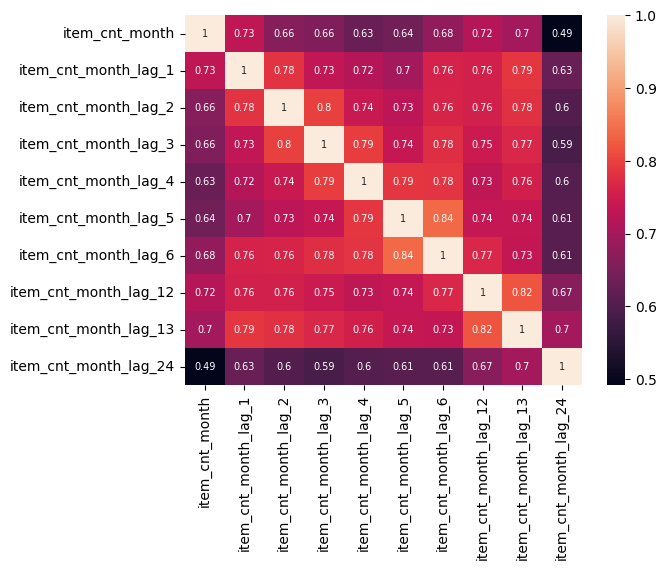

In [26]:
sns.heatmap(lagged[['item_cnt_month',*[f'item_cnt_month_lag_{i}' for i in item_lags]]].corr(),annot=True,annot_kws={'fontsize':7})

<Axes: >

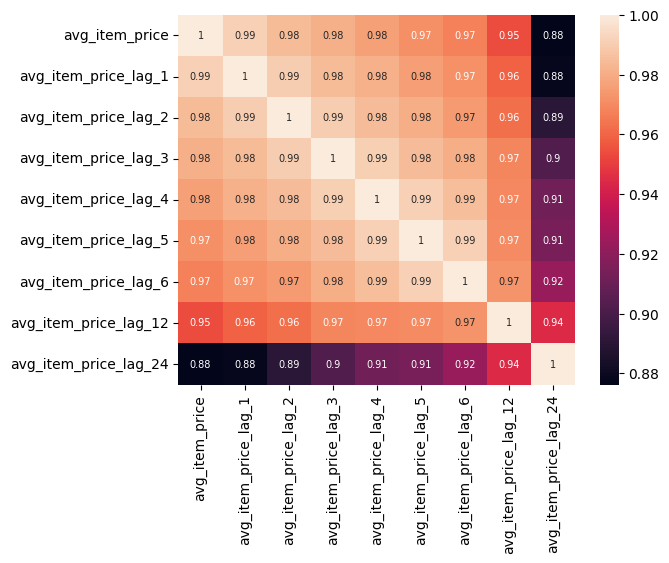

In [27]:
sns.heatmap(lagged[['avg_item_price',*[f'avg_item_price_lag_{i}' for i in price_lags]]].corr(),annot=True,annot_kws={'fontsize':7})

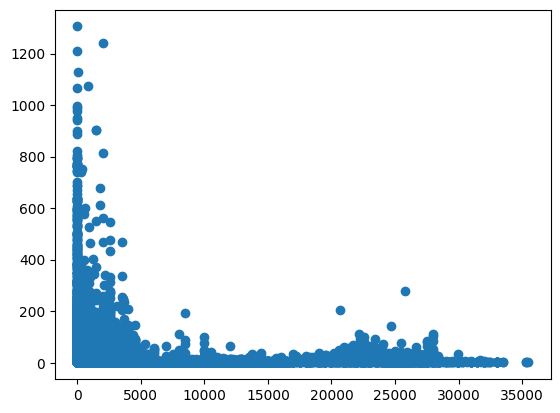

In [28]:

plt.scatter(lagged['avg_item_price_lag_1'],lagged['item_cnt_month'])


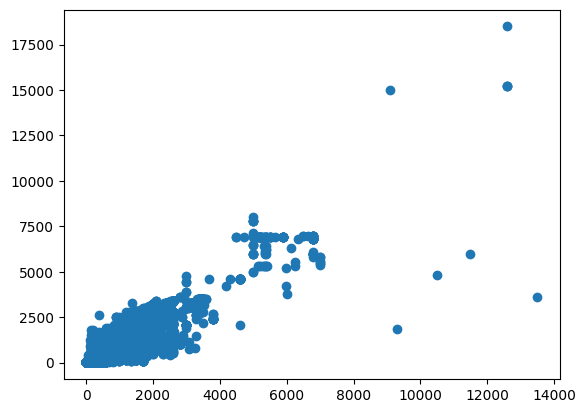

In [29]:

plt.scatter(lagged['avg_item_price_lag_1'],lagged['avg_item_price_lag_24'])


In [30]:
lagged

,shop_id,item_id,date_block_num,avg_item_price,item_cnt_month,item_category_name,month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,...,item_cnt_month_lag_13,item_cnt_month_lag_24,avg_item_price_lag_1,avg_item_price_lag_2,avg_item_price_lag_3,avg_item_price_lag_4,avg_item_price_lag_5,avg_item_price_lag_6,avg_item_price_lag_12,avg_item_price_lag_24
0,2,27,0,2499.0,1.0,Игры - PS3,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,27,17,498.0,1.0,Игры - PS3,6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,30,2,359.0,1.0,Кино - DVD,3,NaN,NaN,1.0,...,1.0,NaN,NaN,NaN,399.0,NaN,NaN,NaN,NaN,NaN
3,2,30,5,399.0,1.0,Кино - DVD,6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,30,15,169.0,1.0,Кино - DVD,4,1.0,NaN,NaN,...,NaN,NaN,169.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608220,59,22164,27,699.0,2.0,Кино - Blu-Ray,4,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,699.0,NaN,NaN,NaN,NaN,NaN
1608221,59,22164,30,699.0,1.0,Кино - Blu-Ray,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1608222,59,22167,9,299.0,1.0,Книги - Методические материалы 1С,10,NaN,2.0,NaN,...,NaN,NaN,NaN,299.0,NaN,NaN,NaN,NaN,NaN,NaN
1608223,59,22167,11,299.0,2.0,Книги - Методические материалы 1С,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,299.0,NaN,NaN


In [31]:
lagged_month = lagged.groupby('month').agg({'item_cnt_month':'sum'}).reset_index()

In [32]:
lagged_month

,month,item_cnt_month
0,1,360391.0
1,2,322775.0
2,3,345171.0
3,4,282131.0
4,5,277519.0
5,6,287443.0
6,7,271985.0
7,8,294692.0
8,9,305967.0
9,10,306622.0


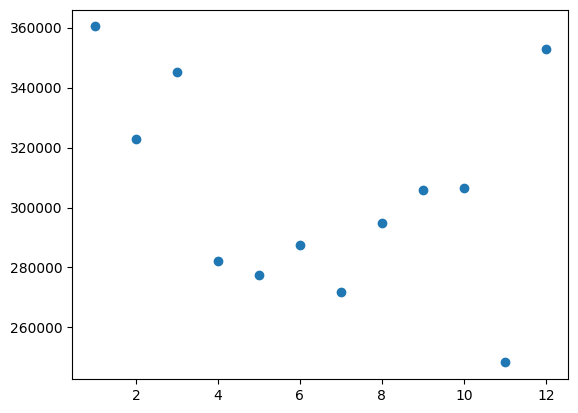

In [33]:

plt.scatter(lagged_month['month'],lagged_month['item_cnt_month'])


In [31]:
grouped['super_category'] = grouped['item_category_name'].apply(lambda a: a.split()[0])

In [67]:
grouped

,shop_id,item_id,date_block_num,avg_item_price,item_cnt_month,item_category_name,month,super_category
0,2,27,0,2499.0,1.0,Игры - PS3,1,Игры
1,2,27,17,498.0,1.0,Игры - PS3,6,Игры
2,2,30,2,359.0,1.0,Кино - DVD,3,Кино
3,2,30,5,399.0,1.0,Кино - DVD,6,Кино
4,2,30,15,169.0,1.0,Кино - DVD,4,Кино
...,...,...,...,...,...,...,...,...
1608220,59,22164,27,699.0,2.0,Кино - Blu-Ray,4,Кино
1608221,59,22164,30,699.0,1.0,Кино - Blu-Ray,7,Кино
1608222,59,22167,9,299.0,1.0,Книги - Методические материалы 1С,10,Книги
1608223,59,22167,11,299.0,2.0,Книги - Методические материалы 1С,12,Книги


In [68]:
grouped_check_by_monthes = grouped[['item_id',
                                    'date_block_num',
                                    'item_category_name',
                                    'super_category',
                                   'shop_id']].groupby(['shop_id','date_block_num']).agg({'item_id':'unique',
                                                                                      'item_category_name':'unique',
                                                                                      'super_category':'unique'})

In [69]:
grouped_check_by_monthes=grouped_check_by_monthes.reset_index()
grouped_check_by_monthes

,shop_id,date_block_num,item_id,item_category_name,super_category
0,2,0,"[27, 33, 317, 438, 471, 481, 482, 484, 491, 53...","[Игры - PS3, Кино - Blu-Ray, Книги - Аудиокниг...","[Игры, Кино, Книги, Программы, Подарки, Музыка..."
1,2,1,"[31, 482, 484, 496, 785, 791, 835, 839, 963, 1...","[Кино - Blu-Ray, Программы - 1С:Предприятие 8,...","[Кино, Программы, Книги, Игры, Подарки, Аксесс..."
2,2,2,"[30, 31, 482, 484, 687, 785, 791, 835, 1007, 1...","[Кино - DVD, Кино - Blu-Ray, Программы - 1С:Пр...","[Кино, Программы, Книги, Подарки, Игры, Музыка..."
3,2,3,"[31, 464, 482, 484, 485, 534, 791, 835, 839, 9...","[Кино - Blu-Ray, Книги - Методические материал...","[Кино, Книги, Программы, Подарки, Игры, Аксесс..."
4,2,4,"[482, 484, 485, 491, 534, 687, 785, 790, 791, ...","[Программы - 1С:Предприятие 8, Программы - Обу...","[Программы, Книги, Кино, Игры, Музыка, Аксессу..."
...,...,...,...,...,...
1577,59,29,"[70, 482, 486, 829, 952, 987, 1010, 1075, 1099...","[Книги - Методические материалы 1С, Программы ...","[Книги, Программы, Кино, Подарки, Музыка, Игры..."
1578,59,30,"[33, 472, 482, 486, 948, 949, 950, 952, 968, 9...","[Кино - Blu-Ray, Книги - Методические материал...","[Кино, Книги, Программы, Игры, Музыка, Аксессу..."
1579,59,31,"[31, 472, 806, 971, 972, 978, 982, 1075, 1108,...","[Кино - Blu-Ray, Книги - Методические материал...","[Кино, Книги, Музыка, Игры, Подарки, Программы..."
1580,59,32,"[486, 491, 787, 806, 1010, 1077, 1233, 1241, 1...","[Программы - 1С:Предприятие 8, Книги - Методич...","[Программы, Книги, Подарки, Кино, Музыка, Игры..."


In [70]:
grouped_check_by_monthes.index

RangeIndex(start=0, stop=1582, step=1)

In [73]:
grouped_check_by_monthes

,shop_id,date_block_num,item_id,item_category_name,super_category
0,2,0,"[27, 33, 317, 438, 471, 481, 482, 484, 491, 53...","[Игры - PS3, Кино - Blu-Ray, Книги - Аудиокниг...","[Игры, Кино, Книги, Программы, Подарки, Музыка..."
1,2,1,"[31, 482, 484, 496, 785, 791, 835, 839, 963, 1...","[Кино - Blu-Ray, Программы - 1С:Предприятие 8,...","[Кино, Программы, Книги, Игры, Подарки, Аксесс..."
2,2,2,"[30, 31, 482, 484, 687, 785, 791, 835, 1007, 1...","[Кино - DVD, Кино - Blu-Ray, Программы - 1С:Пр...","[Кино, Программы, Книги, Подарки, Игры, Музыка..."
3,2,3,"[31, 464, 482, 484, 485, 534, 791, 835, 839, 9...","[Кино - Blu-Ray, Книги - Методические материал...","[Кино, Книги, Программы, Подарки, Игры, Аксесс..."
4,2,4,"[482, 484, 485, 491, 534, 687, 785, 790, 791, ...","[Программы - 1С:Предприятие 8, Программы - Обу...","[Программы, Книги, Кино, Игры, Музыка, Аксессу..."
...,...,...,...,...,...
1577,59,29,"[70, 482, 486, 829, 952, 987, 1010, 1075, 1099...","[Книги - Методические материалы 1С, Программы ...","[Книги, Программы, Кино, Подарки, Музыка, Игры..."
1578,59,30,"[33, 472, 482, 486, 948, 949, 950, 952, 968, 9...","[Кино - Blu-Ray, Книги - Методические материал...","[Кино, Книги, Программы, Игры, Музыка, Аксессу..."
1579,59,31,"[31, 472, 806, 971, 972, 978, 982, 1075, 1108,...","[Кино - Blu-Ray, Книги - Методические материал...","[Кино, Книги, Музыка, Игры, Подарки, Программы..."
1580,59,32,"[486, 491, 787, 806, 1010, 1077, 1233, 1241, 1...","[Программы - 1С:Предприятие 8, Книги - Методич...","[Программы, Книги, Подарки, Кино, Музыка, Игры..."


In [77]:
item_name=grouped_check_by_monthes['item_id']
item_category_name=grouped_check_by_monthes['item_category_name']
super_category=grouped_check_by_monthes['super_category']

sub_cat_diff = []
super_cat_difff = []
name_difff = []
for row in grouped_check_by_monthes.index[:-1]:
    
    item_category_name_diff  = set(item_category_name[row+1]) - set(item_category_name[row])
    super_category_name_diff  = set(super_category[row+1]) - set(super_category[row])
    item_name_diff  = set(item_name[row+1]) - set(item_name[row])
    
    sub_cat_diff.append(list(item_category_name_diff))
    super_cat_difff.append(list(super_category_name_diff))
    name_difff.append(list(item_name_diff))

print(len(sub_cat_diff))
print(len(super_cat_difff))
print(len(name_difff))
df = pd.DataFrame({'num_block and shop_id':range(0,1581),
                   'sub_category_diffs':[len(el) for el in sub_cat_diff],
                   'super_cat_difff': [len(el) for el in super_cat_difff],
                   'item_diff': [len(el) for el in name_difff]})

1581
1581
1581


In [80]:
df.describe()# - dataframe where we can see how many new *SMTH* appeared each month

,num_block and shop_id,sub_category_diffs,super_cat_difff,item_diff
count,1581.000000,1581.000000,1581.000000,1581.000000
mean,790.000000,2.958887,0.259962,585.898798
std,456.539703,2.997502,0.663781,324.199755
min,0.000000,0.000000,0.000000,1.000000
25%,395.000000,1.000000,0.000000,386.000000
50%,790.000000,3.000000,0.000000,500.000000
75%,1185.000000,4.000000,0.000000,704.000000
max,1580.000000,44.000000,9.000000,3287.000000


In [36]:
grouped_check_by_monthes

,item_category_name,super_category
date_block_num,,
0,"[Игры - PS3, Кино - Blu-Ray, Книги - Аудиокниг...","[Игры, Кино, Книги, Программы, Подарки, Музыка..."
1,"[Кино - Blu-Ray, Программы - 1С:Предприятие 8,...","[Кино, Программы, Книги, Игры, Подарки, Аксесс..."
2,"[Кино - DVD, Кино - Blu-Ray, Программы - 1С:Пр...","[Кино, Программы, Книги, Подарки, Игры, Музыка..."
3,"[Кино - Blu-Ray, Книги - Методические материал...","[Кино, Книги, Программы, Подарки, Игры, Аксесс..."
4,"[Программы - 1С:Предприятие 8, Программы - Обу...","[Программы, Книги, Кино, Игры, Музыка, Аксессу..."
5,"[Кино - DVD, Книги - Методические материалы 1С...","[Кино, Книги, Программы, Музыка, Подарки, Игры..."
6,"[Книги - Методические материалы 1С, Программы ...","[Книги, Программы, Кино, Подарки, Игры, Аксесс..."
7,"[Книги - Методические материалы 1С, Программы ...","[Книги, Программы, Игры, Аксессуары, Музыка, К..."
8,"[Книги - Методические материалы 1С, Программы ...","[Книги, Программы, Кино, Игры, Игровые, Аксесс..."


In [34]:
lagged_fist_month=lagged[lagged['item_cnt_month_lag_1'].isna()]
lagged_fist_month.drop(['shop_id','item_id','date_block_num','avg_item_price','item_cnt_month','item_category_name','month'],axis=1)

,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_12,item_cnt_month_lag_13,item_cnt_month_lag_24,avg_item_price_lag_1,avg_item_price_lag_2,avg_item_price_lag_3,avg_item_price_lag_4,avg_item_price_lag_5,avg_item_price_lag_6,avg_item_price_lag_12,avg_item_price_lag_24
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,399.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608220,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,699.0,NaN,NaN,NaN,NaN,NaN
1608221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1608222,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,299.0,NaN,NaN,NaN,NaN,NaN,NaN
1608223,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,299.0,NaN,NaN


In [35]:
lagged_fist_month= lagged_fist_month[lagged_fist_month.isna().sum(axis=1) == 17]


In [36]:
#средняя цена категории и суперкатегории в прошлом месяце для тех кто первый раз
#есть вещи которые не продавались ни разу

In [37]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [19]:
grouped

,shop_id,item_id,date_block_num,avg_item_price,item_cnt_month,item_category_name,month
0,2,27,0,2499.0,1.0,Игры - PS3,1
1,2,27,17,498.0,1.0,Игры - PS3,6
2,2,30,2,359.0,1.0,Кино - DVD,3
3,2,30,5,399.0,1.0,Кино - DVD,6
4,2,30,15,169.0,1.0,Кино - DVD,4
...,...,...,...,...,...,...,...
1608220,59,22164,27,699.0,2.0,Кино - Blu-Ray,4
1608221,59,22164,30,699.0,1.0,Кино - Blu-Ray,7
1608222,59,22167,9,299.0,1.0,Книги - Методические материалы 1С,10
1608223,59,22167,11,299.0,2.0,Книги - Методические материалы 1С,12


In [38]:
def id_to_cat(id):
    return items[items['item_id'] == id]['item_category_id']

In [20]:
grouped_category=grouped.groupby(['item_category_name','shop_id','date_block_num']).agg({'avg_item_price':'mean',
                                                                    'item_cnt_month':'mean',
                                                                    'month':'unique'})#take some time

In [21]:
grouped_category=grouped_category.reset_index()
grouped_category['month']=grouped_category['month'].apply(lambda a:a[0])
grouped_category

,item_category_name,shop_id,date_block_num,avg_item_price,item_cnt_month,month
0,PC - Гарнитуры/Наушники,25,0,148.0,1.000000,1
1,PC - Гарнитуры/Наушники,38,3,22.4,1.000000,4
2,PC - Гарнитуры/Наушники,57,1,93.0,1.000000,2
3,Аксессуары - PS2,45,0,148.0,1.000000,1
4,Аксессуары - PS2,57,1,283.0,1.000000,2
...,...,...,...,...,...,...
65159,Элементы питания,59,29,119.0,2.500000,6
65160,Элементы питания,59,30,119.0,6.000000,7
65161,Элементы питания,59,31,139.0,3.333333,8
65162,Элементы питания,59,32,139.0,2.333333,9


In [24]:
item_lags=list([*range(1,7),12,13,24])
price_lags=list([*range(1,7),12,24])

In [25]:

def create_lags_categories(data,item_lags=None,price_lags=None):
    lagged_items = data[['date_block_num','item_cnt_month','shop_id','item_category_name']].copy()
    for lag in item_lags:
        lagged_items['date_block_num']-=lag#previous month becomes present
        data=data.merge(lagged_items, how='left',on=['date_block_num','shop_id','item_category_name'], suffixes=('', f'_lag_{lag}'))
        lagged_items['date_block_num']+=lag

    lagged_prices = data[['date_block_num','avg_item_price','shop_id','item_category_name']].copy()
    for lag in price_lags:
        lagged_prices['date_block_num']-=lag#previous month becomes present
        data=data.merge(lagged_prices, how='left',on=['date_block_num','shop_id','item_category_name'], suffixes=('', f'_lag_{lag}'))
        lagged_prices['date_block_num']+=lag

        
    return data

,shop_id,item_id,date_block_num,avg_item_price,item_cnt_month,item_category_name,month
0,2,27,0,2499.0,1.0,Игры - PS3,1
1,2,27,17,498.0,1.0,Игры - PS3,6
2,2,30,2,359.0,1.0,Кино - DVD,3
3,2,30,5,399.0,1.0,Кино - DVD,6
4,2,30,15,169.0,1.0,Кино - DVD,4
...,...,...,...,...,...,...,...
1608220,59,22164,27,699.0,2.0,Кино - Blu-Ray,4
1608221,59,22164,30,699.0,1.0,Кино - Blu-Ray,7
1608222,59,22167,9,299.0,1.0,Книги - Методические материалы 1С,10
1608223,59,22167,11,299.0,2.0,Книги - Методические материалы 1С,12


In [26]:
grouped_category_lagged = create_lags_categories(grouped_category,item_lags=item_lags,price_lags=price_lags)
grouped_category_lagged

,item_category_name,shop_id,date_block_num,avg_item_price,item_cnt_month,month,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,...,item_cnt_month_lag_13,item_cnt_month_lag_24,avg_item_price_lag_1,avg_item_price_lag_2,avg_item_price_lag_3,avg_item_price_lag_4,avg_item_price_lag_5,avg_item_price_lag_6,avg_item_price_lag_12,avg_item_price_lag_24
0,PC - Гарнитуры/Наушники,25,0,148.0,1.000000,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PC - Гарнитуры/Наушники,38,3,22.4,1.000000,4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PC - Гарнитуры/Наушники,57,1,93.0,1.000000,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Аксессуары - PS2,45,0,148.0,1.000000,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Аксессуары - PS2,57,1,283.0,1.000000,2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65159,Элементы питания,59,29,119.0,2.500000,6,6.000000,3.333333,2.333333,3.0,...,NaN,NaN,119.0,139.0,139.0,139.0,NaN,NaN,NaN,NaN
65160,Элементы питания,59,30,119.0,6.000000,7,3.333333,2.333333,3.000000,NaN,...,NaN,NaN,139.0,139.0,139.0,NaN,NaN,NaN,NaN,NaN
65161,Элементы питания,59,31,139.0,3.333333,8,2.333333,3.000000,NaN,NaN,...,NaN,NaN,139.0,139.0,NaN,NaN,NaN,NaN,NaN,NaN
65162,Элементы питания,59,32,139.0,2.333333,9,3.000000,NaN,NaN,NaN,...,NaN,NaN,139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
grouped_category_lagged.isna().sum()

item_category_name           0
shop_id                      0
date_block_num               0
avg_item_price               0
item_cnt_month               0
month                        0
item_cnt_month_lag_1      6249
item_cnt_month_lag_2      8867
item_cnt_month_lag_3     11386
item_cnt_month_lag_4     13836
item_cnt_month_lag_5     16201
item_cnt_month_lag_6     18432
item_cnt_month_lag_12    31207
item_cnt_month_lag_13    33265
item_cnt_month_lag_24    52163
avg_item_price_lag_1      6249
avg_item_price_lag_2      8867
avg_item_price_lag_3     11386
avg_item_price_lag_4     13836
avg_item_price_lag_5     16201
avg_item_price_lag_6     18432
avg_item_price_lag_12    31207
avg_item_price_lag_24    52163
dtype: int64

In [44]:
grouped['super_category'] = grouped['item_category_name'].apply(lambda a: a.split()[0])

In [45]:
grouped['super_category'].unique()

array(['Игры', 'Кино', 'Музыка', 'Книги', 'Программы', 'Подарки', 'Карты',
       'Аксессуары', 'Игровые', 'Билеты', 'Чистые', 'Служебные',
       'Элементы', 'Доставка', 'PC'], dtype=object)

In [46]:
grouped_super_category=grouped.groupby(['super_category','shop_id','date_block_num']).agg({'avg_item_price':'mean',
                                                                    'item_cnt_month':'mean',
                                                                    'month':'unique'})#take some tim

grouped_super_category=grouped_super_category.reset_index()
grouped_super_category['month']=grouped_super_category['month'].apply(lambda a:a[0])
grouped_super_category

,super_category,shop_id,date_block_num,avg_item_price,item_cnt_month,month
0,PC,25,0,148.000000,1.000000,1
1,PC,38,3,22.400000,1.000000,4
2,PC,57,1,93.000000,1.000000,2
3,Аксессуары,2,0,1822.868968,2.481481,1
4,Аксессуары,2,1,1466.666667,1.750000,2
...,...,...,...,...,...,...
16133,Элементы,59,29,119.000000,2.500000,6
16134,Элементы,59,30,119.000000,6.000000,7
16135,Элементы,59,31,139.000000,3.333333,8
16136,Элементы,59,32,139.000000,2.333333,9


In [47]:

def create_lags_super_categories(data,item_lags=None,price_lags=None):
    lagged_items = data[['date_block_num','item_cnt_month','shop_id','super_category']].copy()
    for lag in item_lags:
        lagged_items['date_block_num']-=lag#previous month becomes present
        data=data.merge(lagged_items, how='left',on=['date_block_num','super_category'], suffixes=('', f'_lag_{lag}'))
        lagged_items['date_block_num']+=lag

    lagged_prices = data[['date_block_num','avg_item_price','super_category']].copy()
    for lag in price_lags:
        lagged_prices['date_block_num']-=lag#previous month becomes present
        data=data.merge(lagged_prices, how='left',on=['date_block_num','super_category'], suffixes=('', f'_lag_{lag}'))
        lagged_prices['date_block_num']+=lag

        
    return data

In [ ]:
grouped_super_category_lagged = create_lags_super_categories(grouped_super_category,item_lags=item_lags,price_lags=price_lags)
grouped_super_category_lagged

In [ ]:
grouped_super_category_lagged.isna().sum()